In [2]:
%matplotlib inline
from scipy import signal
from scipy import sparse
from scipy import optimize
import matplotlib.pyplot as plt
import numpy as np
from numpy import matlib
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D
import time
from numba import jit

In [8]:
def sparsePDMatrix(Nx,sparseness):
    # Generate a sparse random symmetric matrix of size Nx by Nx
    J = np.tril(np.random.randn(Nx,Nx),k=-1)
    J = (J + J.T)/2 + np.diag(np.abs(np.random.randn(Nx))) # make a symmetric J
    
    # create the mask for zeros
    H = np.random.rand(Nx,Nx)   # Sparse selection matrix
    H = np.tril(H,k=-1)         # make diagonal and upper triangle of the matrix zero
    H[H < sparseness] = 0
    H[H >= sparseness] = 1
    H = H + H.T + np.eye(Nx) # elements of H which are 1 will be retained in J
    
    J = np.multiply(J,H)

    eps = 0.1
    mineigval = min(np.linalg.eigvals(J))
    J = J - np.diag(mineigval*np.ones(Nx) - eps)
    
    return J

def powersofJ(J,P):
    Nx = np.shape(J)[0]
    J_p = np.ones([Nx,Nx,P+1])
    
    for ii in range(P+1):
        J_p[:,:,ii] = J**ii
    
    return J_p
        
@jit
def sigmoid(x):
    return 1/(1+np.exp(-x))

@jit
def TAPF(xt,ht,J_p,G):
    
    Nx = np.shape(xt)[0]
    
    
    # Here we are assuming the indices a,b,c in G_abc are in {0,1,2}
    
    # LUT for indices
    LUT = np.array([[0,0,0],[0,0,1],[0,0,2],[0,1,0],[0,1,1],[0,1,2],[0,2,0],[0,2,1],[0,2,2],[1,0,0],[1,0,1],[1,0,2],[1,1,0],[1,1,1],[1,1,2],[1,2,0],[1,2,1],[1,2,2],[2,0,0],[2,0,1],[2,0,2],[2,1,0],[2,1,1],[2,1,2],[2,2,0],[2,2,1],[2,2,2]])
    
    # Powers of JMat and xt
    xt_p = np.ones([Nx,3])
    
    for ii in range(3):
        xt_p[:,ii] = xt**ii
        
        
    Ng = len(G)
    
    Im1Mat = np.zeros([Nx,Ng])
    Im2Mat = np.zeros([Nx,Ng])
    EtaMat = np.zeros([Nx,Nx,Ng])

    
    for ii in range(Ng):
        
        a = LUT[ii,0]
        b = LUT[ii,1]
        c = LUT[ii,2]
        Ja = J_p[:,:,a]
        xb = xt_p[:,b]
        xc = xt_p[:,c]
        
        Im1Mat[:,ii] = xb*np.dot(Ja,xc)
        Im2Mat[:,ii] = G[ii]*Im1Mat[:,ii]
        
        if ii > 8:
            outerprod = np.dot(np.expand_dims(xb, 1), np.expand_dims(xc, 1).T)
            EtaMat[:,:,ii] = G[ii]*a*J_p[:,:,a-1]*outerprod
            
    argf = np.sum(Im2Mat,axis=1) + ht
    out  = sigmoid(argf)
    
    EtaMat = np.sum(EtaMat,axis=2)
        
    return out,argf,Im1Mat,EtaMat
    
@jit
def runTAP(x0, hMat, lam, Qpr, Qobs, U, J, G):
    T = np.shape(hMat)[1]
    J_p = powersofJ(J,2)
    Nx = len(x0)
    
    xMat = np.zeros([Nx,T])
    xold = x0
    
    for tt in range(T):
        ht = hMat[:,tt]
        out, arfg = TAPF(xold, ht, J_p, G)[0:2]
        xnew = (1-lam)*xold + lam*out
        
        xMat[:,tt] = xnew + np.random.multivariate_normal(np.zeros(Nx),Qpr,1).flatten()
        xold = xnew
    
    
    Nr   = np.shape(U)[0]
    rMat = np.dot(U,xMat) + np.random.multivariate_normal(np.zeros(Nr),Qobs,T).T
        
    return xMat,rMat


def generateH(Nx,T,Nh,scaling):
    hInd = scaling*np.random.randn(Nx,int(np.ceil(T/Nh)))
    hMat = np.zeros([Nx,T])
    for tt in range(T):
        hMat[:,tt] = hInd[:,int(np.floor(tt/Nh))]
    return hMat

def mvnormpdf(x,mean,covmat):
    Nx = np.shape(x)[0]
    if Nx == 1:
        xm = x - mean
        qsum = xm**2/covmat
        out = np.exp(-qsum/2)/np.sqrt(2*np.pi*covmat)
    else:    
        xm = x - mean
        P = np.linalg.inv(covmat)
        qsum = np.dot(np.dot(xm,P),xm)
        det = np.linalg.det(covmat)
        out = np.exp(-qsum/2)/np.power(2*np.pi,Nx/2)/np.sqrt(det)

    return out

def JVecToMat(JVec,Nx):
    JMat = np.zeros([Nx,Nx])
    for kk in range(Nx):
        JMat[kk:,kk] = JVec[0:Nx-kk]
        JMat[kk,kk:] = JVec[0:Nx-kk]
        JVec = np.delete(JVec,np.arange(Nx-kk))
        
    return JMat

def JMatToVec(JMat):
    Nx = np.shape(JMat)[0]
    JVec = np.zeros([1])
    
    for kk in range(Nx):
        JVec = np.concatenate((JVec,JMat[kk:,kk].flatten()),axis=0)
        
    JVec = JVec[1:]
        
    return JVec
        
        
            
    
    


In [4]:
@jit
def particlefilter(rMat, hMat, K, lam, Qpr, Qobs, U, J, G):
    # Particle filter code
    
    T  = np.shape(rMat)[1]
    Nx = np.shape(U)[1]
    

    ParticlesAll_BS = np.zeros([Nx,K,T]) # before sampling
    ParticlesAll_AS = np.zeros([Nx,K,T]) # after sampling

    ParticlesOld = np.random.rand(Nx,K) # intialize particles
   
    J_p = powersofJ(J,2)
    
    for tt in range(T):
        ht = hMat[:,tt]
        ParticlesNew = np.zeros([Nx,K])
        WVec = np.zeros(K)

        for ii in range(K):
            # sampling x(t) from the proposal distribution --> posterior
            pNew = (1-lam)*ParticlesOld[:,ii] + lam*TAPF(ParticlesOld[:,ii],ht,J_p,G)[0]
            
            # get the mean and covariance of the posterior
            Q_post = np.linalg.inv(np.linalg.inv(Qpr) + np.dot(U.T,np.linalg.solve(Qobs,U)))
            mu_post = np.dot(Q_post,np.linalg.solve(Qpr,pNew) + np.dot(U.T,np.linalg.solve(Qobs,rMat[:,tt])))
            
            ParticlesNew[:,ii] = np.random.multivariate_normal(mu_post,Q_post,1).flatten()
                
            mu = np.dot(U,ParticlesNew[:,ii])
            WVec[ii] = mvnormpdf(rMat[:,tt],mu,Qobs) + 1e-64

        WVec = WVec/np.sum(WVec)

        ParticlesAll_BS[:,:,tt] = ParticlesNew


        # Now to resample the particles by drawing samples from a multinomial dist.
        NVec = np.random.multinomial(K,WVec,size=1).flatten()
            
        ParticlesRS = np.zeros([1,Nx])
        
        for ii in range(K):
            if NVec[ii] != 0:
                repP = matlib.repmat(ParticlesNew[:,ii],NVec[ii],1)
                ParticlesRS = np.concatenate((ParticlesRS,repP),axis=0)

        ParticlesRS = ParticlesRS[1:K+1,:]

        ParticlesAll_AS[:,:,tt] = ParticlesRS.T
        ParticlesOld = ParticlesRS.T
        
    xhat = np.mean(ParticlesAll_AS,axis=1)
    return xhat, ParticlesAll_AS, ParticlesAll_BS

In [9]:
def NegLL(theta, rMat, hMat, P_AS, P_BS, lam, Qpr, Qobs):
    
    
    Nr = np.shape(rMat)[0]
    Nx,K,T = np.shape(P_BS)
    
    
    G = theta[0:27]
    NJ = int(Nx*(Nx+1)/2)
    JVec = theta[27:27+NJ]
    J = JVecToMat(JVec,Nx)
    U = np.reshape(theta[27+NJ:],(Nr,Nx),order='F')
    
    
    C1 = 0
    C2 = 0
    
    J_p = powersofJ(J,2)
    
    dG = G*0
    dJ = J*0
    dU = U*0
    
    for t in range(1,T):
        
        r_t = rMat[:,t]
        ht  = hMat[:,t]
        
        for k in range(K):
            x_old = P_AS[:,k,t-1]
            x_curr = P_BS[:,k,t]
            out, argf, Im1Mat, EtaMat = TAPF(x_old, ht, J_p, G)
            xpred = (1-lam)*x_old + lam*out
            
            C1 = C1 + 0.5*np.dot(x_curr - xpred,np.linalg.solve(Qpr,x_curr-xpred))
            C2 = C2 + 0.5*np.dot(r_t - np.dot(U,x_curr),np.linalg.solve(Qobs,r_t-np.dot(U,x_curr)))
            
            sigder = sigmoid(argf)*(1-sigmoid(argf))
            repsigder = np.tile(np.expand_dims(sigder,1),(1,len(G)))
            
            temp = lam*np.dot(x_curr - xpred,np.linalg.solve(Qpr,repsigder*Im1Mat))
            dG = dG + temp
            
            dJtemp = J*0
            
            for ii in range(Nx):
                for jj in range(ii+1):
                    df = np.zeros([Nx])
                    if jj == ii:
                        df[ii] = sigder[ii]*EtaMat[ii,ii]
                    else:
                        if J[ii,jj] != 0:
                            
                            df[ii] = sigder[ii]*EtaMat[ii,jj]
                            df[jj] = sigder[jj]*EtaMat[jj,ii]
                    
                    dJtemp[ii,jj] = lam*np.dot(x_curr - xpred,np.linalg.solve(Qpr,df))
                    
            dJ = dJ + dJtemp
            dU = dU + np.linalg.solve(Qobs,np.outer(r_t - np.dot(U,x_curr),x_curr))
                    
    C = (C1 + C2)/K
    
    dG = -dG/K
    dG[0:10] = 0
    dG[18] = 0
    
    dJ = -dJ/K
    dU = -dU/K
    
    dtheta = np.concatenate((dG,JMatToVec(dJ),dU.flatten('F')),axis = 0)
    
    return C, dtheta





In [50]:
def NegLLFn(theta, rMat, hMat, P_AS, P_BS, lam, Qpr, Qobs):
    
    
    Nr = np.shape(rMat)[0]
    Nx,K,T = np.shape(P_BS)
    
    
    G = theta[0:27]
    NJ = int(Nx*(Nx+1)/2)
    JVec = theta[27:27+NJ]
    J = JVecToMat(JVec,Nx)
    U = np.reshape(theta[27+NJ:],(Nr,Nx),order='F')
    
    
    C1 = 0
    C2 = 0
    
    J_p = powersofJ(J,2)
    
    dG = G*0
    dJ = J*0
    dU = U*0
    
    for t in range(1,T):
        
        r_t = rMat[:,t]
        ht  = hMat[:,t]
        
        for k in range(K):
            x_old = P_AS[:,k,t-1]
            x_curr = P_BS[:,k,t]
            out, argf, Im1Mat, EtaMat = TAPF(x_old, ht, J_p, G)
            xpred = (1-lam)*x_old + lam*out
            
            C1 = C1 + 0.5*np.dot(x_curr - xpred,np.linalg.solve(Qpr,x_curr-xpred))
            C2 = C2 + 0.5*np.dot(r_t - np.dot(U,x_curr),np.linalg.solve(Qobs,r_t-np.dot(U,x_curr)))
            
                    
    C = (C1 + C2)/K
    
    
    return C

def NegLLDer(theta, rMat, hMat, P_AS, P_BS, lam, Qpr, Qobs):
    
    
    Nr = np.shape(rMat)[0]
    Nx,K,T = np.shape(P_BS)
    
    
    G = theta[0:27]
    NJ = int(Nx*(Nx+1)/2)
    JVec = theta[27:27+NJ]
    J = JVecToMat(JVec,Nx)
    U = np.reshape(theta[27+NJ:],(Nr,Nx),order='F')
    
    
    C1 = 0
    C2 = 0
    
    J_p = powersofJ(J,2)
    
    dG = G*0
    dJ = J*0
    dU = U*0
    
    for t in range(1,T):
        
        r_t = rMat[:,t]
        ht  = hMat[:,t]
        
        for k in range(K):
            x_old = P_AS[:,k,t-1]
            x_curr = P_BS[:,k,t]
            out, argf, Im1Mat, EtaMat = TAPF(x_old, ht, J_p, G)
            xpred = (1-lam)*x_old + lam*out
            
            #C1 = C1 + 0.5*np.dot(x_curr - xpred,np.linalg.solve(Qpr,x_curr-xpred))
            #C2 = C2 + 0.5*np.dot(r_t - np.dot(U,x_curr),np.linalg.solve(Qobs,r_t-np.dot(U,x_curr)))
            
            sigder = sigmoid(argf)*(1-sigmoid(argf))
            repsigder = np.tile(np.expand_dims(sigder,1),(1,len(G)))
            
            temp = lam*np.dot(x_curr - xpred,np.linalg.solve(Qpr,repsigder*Im1Mat))
            dG = dG + temp
            
            dJtemp = J*0
            
            for ii in range(Nx):
                for jj in range(ii+1):
                    df = np.zeros([Nx])
                    if jj == ii:
                        df[ii] = sigder[ii]*EtaMat[ii,ii]
                    else:
                        if J[ii,jj] != 0:
                            
                            df[ii] = sigder[ii]*EtaMat[ii,jj]
                            df[jj] = sigder[jj]*EtaMat[jj,ii]
                    
                    dJtemp[ii,jj] = lam*np.dot(x_curr - xpred,np.linalg.solve(Qpr,df))
                    
            dJ = dJ + dJtemp
            dU = dU + np.linalg.solve(Qobs,np.outer(r_t - np.dot(U,x_curr),x_curr))
                    
    C = (C1 + C2)/K
    
    dG = -dG/K
    dG[0:10] = 0
    dG[18] = 0
    
    dJ = -dJ/K
    dU = -dU/K
    
    dtheta = np.concatenate((dG,JMatToVec(dJ),dU.flatten('F')),axis = 0)
    
    return dtheta








In [12]:
Nx = 3
Nr = 6
T  = 100
Nh = 10 
lam = 0.25

sp = 0.5
gj = 4/Nx
J = gj*sparsePDMatrix(Nx,sp)
G = [0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,4,-4,0,-8,8,0,0,0]
U = np.random.randn(Nr,Nx)

# generate inputs
gh = 1
hMat = generateH(Nx,T,Nh,gh)

Qpr  = 1e-4*np.eye(Nx)
Qobs = 4e-4*np.eye(Nr)

# initial values for the TAP dynamics
x0 = np.random.rand(Nx)

# generate the latent dynamics and observations
xMat, rMat = runTAP(x0, hMat, lam, Qpr, Qobs, U, J, G)
xMat2 = runTAP(x0, hMat, lam, Qpr, Qobs, U, J*0, G)[0]

# run the PF with true values of (U, J, G)

K = 100 # no. of particles

t0 = time.time()
x_truedec, P_AS_truedec, P_BS_truedec = particlefilter(rMat, hMat, K, lam, Qpr, Qobs, U, J, G)
t1 = time.time()
print(t1 - t0)
r_truedec = np.dot(U,x_truedec)

# # Compute the cost and derivatives
# theta = np.concatenate((G,JMatToVec(J),U.flatten('F')), axis=0)
# C_truedec, dtheta_td = NegLL(theta, rMat, hMat, P_AS_truedec, P_BS_truedec, lam, Qpr, Qobs)


# choose initial values for parameters
H = sigmoid(hMat)
U_1 = np.linalg.lstsq(H.T,rMat.T)[0].T + 0.2*np.random.randn(Nr,Nx)
G_1 = np.random.randn(27)
G_1[0:10] = 0
G_1[19] = 0
J_1 = 1.2*J
#J_1 = gj*sparsePDMatrix(Nx,sp)

t0 = time.time()
x_1, P_AS_1, P_BS_1 = particlefilter(rMat, hMat, K, lam, Qpr, Qobs, U_1, J_1, G_1)
t1 = time.time()
print(t1 - t0)
r_1 = np.dot(U_1,x_1)

# # Compute the cost and derivatives
# theta_1 = np.concatenate((G_1,JMatToVec(J_1),U_1.flatten('F')), axis=0)
# C_1, dtheta_1 = NegLL(theta_1, rMat, hMat, P_AS_1, P_BS_1, lam, Qpr, Qobs)


5.139491081237793
4.756911993026733


In [8]:
# EM part of the code

Cinit = C_1
xinit = x_1
rinit = r_1
Uinit = U_1
Jinit = J_1
Ginit = G_1

EMIters = 2

BS = 20

#optimoptions = {'disp':True,'maxiter':10}

# initialize the batch
si = np.random.randint(T-BS)
idx = np.arange(si,si+BS)
rB = rMat[:,idx]
hB = hMat[:,idx]
P_AS_B = P_AS_1[:,:,idx]
P_BS_B = P_BS_1[:,:,idx]
NJ = int(Nx*(Nx+1)/2)

for iterem in range(EMIters):
    
    theta_1 = np.concatenate((G_1,JMatToVec(J_1),U_1.flatten('F')), axis=0)
    
    MStep = optimize.minimize(NegLLFn, theta_1, args = (rB, hB, P_AS_B, P_BS_B, lam, Qpr, Qobs), method='BFGS', jac = NegLLDer, options={'disp': True,'maxiter':5})

    theta_1 = MStep.x
    
    G_1 = theta_1[0:27] 
    J_1 = JVecToMat(theta_1[27:27+NJ],Nx)
    U_1 = np.reshape(theta_1[27+NJ:],(Nr,Nx),order='F')
    
    # E-step pick a new batch and run PF with new parameters
    si = np.random.randint(T-BS)
    idx = np.arange(si,si+BS)
    rB = rMat[:,idx]
    hB = hMat[:,idx]
    
    x_B, P_AS_B, P_BS_B = particlefilter(rB, hB, K, lam, Qpr, Qobs, U_1, J_1, G_1)



         Current function value: 151.305840
         Iterations: 5
         Function evaluations: 10
         Gradient evaluations: 10
         Current function value: 148.460490
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9


In [10]:
x_1, P_AS_1, P_BS_1 = particlefilter(rMat, hMat, K, lam, Qpr, Qobs, U_1, J_1, G_1)
C_1, dtheta_1 = NegLL(theta_1,rMat, hMat, P_AS_1, P_BS_1, lam, Qpr, Qobs)
r_1 = np.dot(U_1,x_1)
print(C_truedec,Cinit,C_1)

463.78801016 17183.5411373 896.744353117


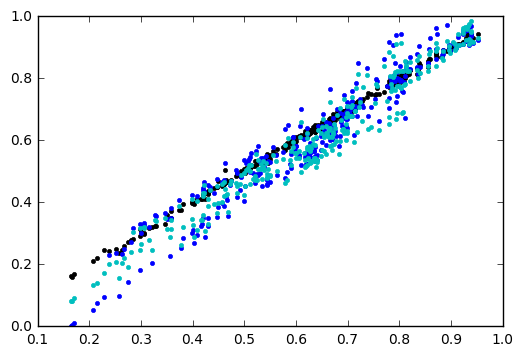

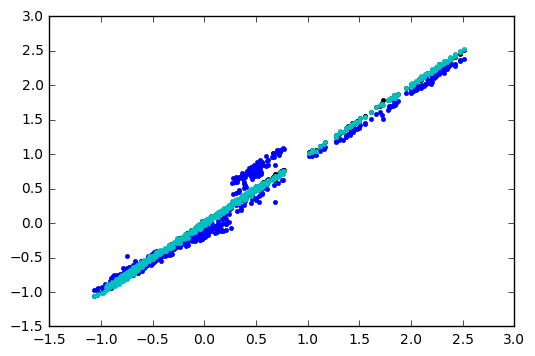

In [11]:
plt.plot(xMat.flatten(),x_truedec.flatten(),'k.')
plt.plot(xMat.flatten(),xinit.flatten(),'b.')
plt.plot(xMat.flatten(),x_1.flatten(),'c.')
plt.show()
plt.plot(rMat.flatten(),r_truedec.flatten(),'k.')
plt.plot(rMat.flatten(),rinit.flatten(),'b.')
plt.plot(rMat.flatten(),r_1.flatten(),'c.')
plt.show()

In [13]:
def fun1(A,B):
    k = 0
    for ii in range(5000):
        C = np.dot(A,B)
    return k

@jit
def fun2(A,B):
    k = 0
    for ii in range(5000):
        C = np.dot(A,B)
    return k

def fun3(A,B):
    k = 0
    for ii in range(5000):
        C = np.matmul(A,B)
    return k

@jit
def fun4(A,B):
    k = 0
    for ii in range(5000):
        C = np.matmul(A,B)
    return k

In [15]:
A = np.random.rand(1000,100)
B = np.random.rand(100,100)

t0 = time.time()
k = fun1(A,B)
t1 = time.time()
print(t1-t0)


t0 = time.time()
k = fun3(A,B)
t1 = time.time()
print(t1-t0)



1.8533871173858643
1.7768969535827637


In [25]:
def fun(k):
    for ii in range(1000000):
        k += 1
    return k

@jit
def fun_numba(k):
    for ii in range(1000000):
        k += 1
    return k

In [26]:
%timeit fun(0)
%timeit fun_numba(0)

10 loops, best of 3: 58.3 ms per loop
The slowest run took 178429.95 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 177 ns per loop
